In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
#下載信用卡欺詐數據集
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

#V1~V28：為PCA後的主要參數
#Time：每一個交易間的秒數
#Amount：為交易金額
#Class：1為詐欺，0為無

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#確認不平衡狀況
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

#僅0.17%有詐欺的數據

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



## Data Preprocessing

In [5]:
#資料前處理

cleaned_df = raw_df.copy()

#去除Time欄位
cleaned_df.pop('Time')

#Amount數值過大，做資料轉換
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [9]:
#資料切割
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

#將labels資料轉換
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [10]:
#資料正規化
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('訓練的標籤shape:', train_labels.shape)
print('驗證的標籤shape:', val_labels.shape)
print('測試的標籤shape:', test_labels.shape)

print('訓練的特徵shape:', train_features.shape)
print('驗證的特徵shape:', val_features.shape)
print('測試的特徵shape:', test_features.shape)

訓練的標籤shape: (182276,)
驗證的標籤shape: (45569,)
測試的標籤shape: (56962,)
訓練的特徵shape: (182276, 29)
驗證的特徵shape: (45569, 29)
測試的特徵shape: (56962, 29)


In [14]:
~bool_train_labels

array([ True,  True,  True, ...,  True,  True,  True])

### Check data distribution

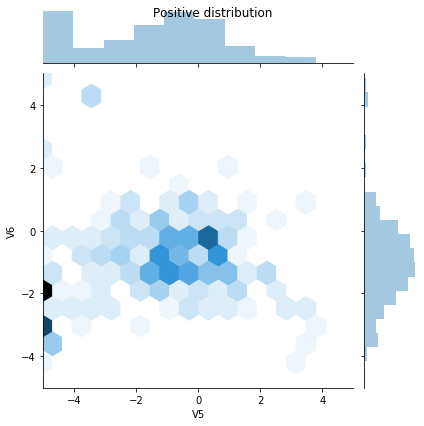

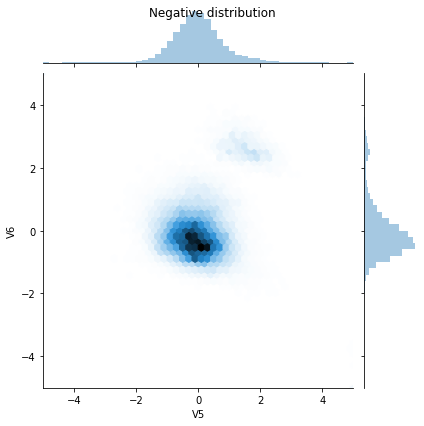

In [18]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns) #取得詐欺的相關資料
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns) #取得無詐欺的相關資料

sns.jointplot(pos_df['V5'],pos_df['V6'],
             kind = 'hex',xlim = (-5,5),ylim = (-5,5))

plt.suptitle('Positive distribution')

sns.jointplot(neg_df['V5'],neg_df['V6'],
              kind = 'hex', xlim = (-5,5),ylim = (-5,5))

_ = plt.suptitle("Negative distribution")

## Define Measuring metrics

In [20]:
METRICS = [
    tf.keras.metrics.TruePositives(name = 'tp'),
    tf.keras.metrics.FalsePositives(name = 'fp'),
    tf.keras.metrics.TrueNegatives(name = 'tn'),
    tf.keras.metrics.FalseNegatives(name = 'fn'),
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name ='precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc'),
]

def make_model(metrics = METRICS,output_bias = None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    model = tf.keras.Sequential([
        
        tf.keras.layers.Dense(16,activation = 'relu',input_shape = (train_features.shape[-1],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1,activation = 'sigmoid',bias_initializer = output_bias),
    ])
    
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3),
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics = metrics)
    
    return model

## Model Training

In [21]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_auc',
        verbose = 1,
        patience = 10,
        mode = 'max',
        restore_best_weights = True
        )

model = make_model()

### Set initial bias

- 比較使用initial bias根部使用的差別

In [22]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [23]:
#確認初始權重

initial_weights = os.path.join(tempfile.mkdtemp(),'initaial_weights')
model.save_weights(initial_weights)


In [25]:
## 不使用bias 的model

model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0]) #權重從0開始
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size = BATCH_SIZE,
    epochs = 20,
    validation_data = (val_features,val_labels),
    verbose = 0)




In [26]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size = BATCH_SIZE,
    epochs = 20,
    validation_data = (val_features,val_labels),
    verbose = 0)


In [27]:
def plot_loss(history, label, n):
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

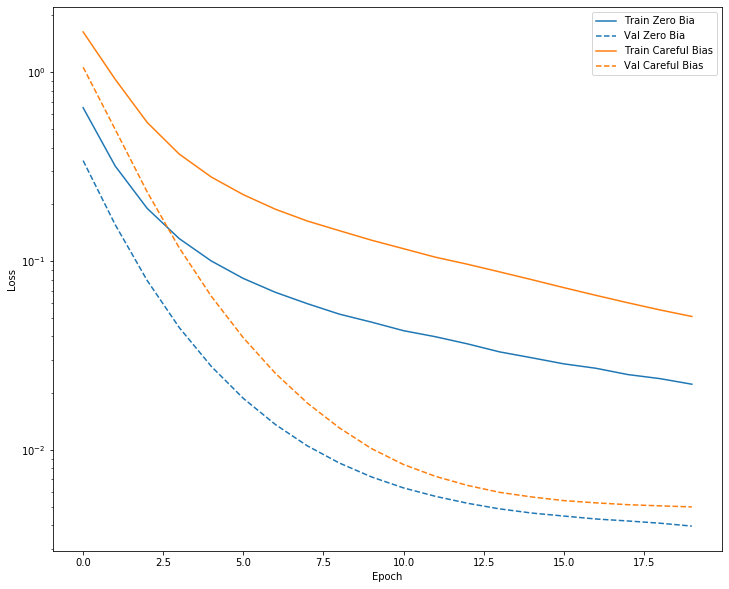

In [28]:
plot_loss(zero_bias_history, "Zero Bia", 0) #0偏移量
plot_loss(careful_bias_history, "Careful Bias", 1) #些微偏移量
plt.legend()

### Define metrics plot function

In [35]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('合法的交易 (True Negatives): ', cm[0][0])
  print('誤判的詐欺交易 (False Positives): ', cm[0][1]) #錯過詐欺交易
  print('遺漏的詐欺交易 (False Negatives): ', cm[1][0]) #增加財務成本
  print('檢測到詐欺交易 (True Positives): ', cm[1][1])
  print('總詐欺交易: ', np.sum(cm[1]))


#ROC

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Weighted labels

In [31]:
weight_for_0 = (1/neg)*(total)/2.0
weight_for_1 = (1/pos)*(total)/2.0

class_weight = {0: weight_for_0, 1:weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [33]:
#添加class_weight，增加關注度

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [early_stopping],
    validation_data = (val_features,val_labels),
    class_weight = class_weight)


Epoch 1/100
90/90 [==============================] - 1s 9ms/step - loss: 0.9577 - tp: 367.0000 - fp: 162562.0000 - tn: 64888.0000 - fn: 28.0000 - accuracy: 0.2864 - precision: 0.0023 - recall: 0.9291 - auc: 0.7940 - val_loss: 1.3592 - val_tp: 68.0000 - val_fp: 40297.0000 - val_tn: 5201.0000 - val_fn: 3.0000 - val_accuracy: 0.1156 - val_precision: 0.0017 - val_recall: 0.9577 - val_auc: 0.9025
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 0.6775 - tp: 306.0000 - fp: 132151.0000 - tn: 49801.0000 - fn: 18.0000 - accuracy: 0.2749 - precision: 0.0023 - recall: 0.9444 - auc: 0.8931 - val_loss: 0.8833 - val_tp: 65.0000 - val_fp: 27614.0000 - val_tn: 17884.0000 - val_fn: 6.0000 - val_accuracy: 0.3939 - val_precision: 0.0023 - val_recall: 0.9155 - val_auc: 0.9044
Epoch 3/100
90/90 [==============================] - 0s 3ms/step - loss: 0.5174 - tp: 304.0000 - fp: 97377.0000 - tn: 84575.0000 - fn: 20.0000 - accuracy: 0.4657 - precision: 0.0031 - recall: 0.9383 - auc: 0.9

Epoch 22/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1723 - tp: 301.0000 - fp: 14814.0000 - tn: 167138.0000 - fn: 23.0000 - accuracy: 0.9186 - precision: 0.0199 - recall: 0.9290 - auc: 0.9808 - val_loss: 0.0855 - val_tp: 64.0000 - val_fp: 1174.0000 - val_tn: 44324.0000 - val_fn: 7.0000 - val_accuracy: 0.9741 - val_precision: 0.0517 - val_recall: 0.9014 - val_auc: 0.9470
Epoch 23/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1819 - tp: 299.0000 - fp: 14989.0000 - tn: 166963.0000 - fn: 25.0000 - accuracy: 0.9176 - precision: 0.0196 - recall: 0.9228 - auc: 0.9783 - val_loss: 0.0888 - val_tp: 64.0000 - val_fp: 1244.0000 - val_tn: 44254.0000 - val_fn: 7.0000 - val_accuracy: 0.9725 - val_precision: 0.0489 - val_recall: 0.9014 - val_auc: 0.9485
Epoch 24/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1642 - tp: 303.0000 - fp: 14782.0000 - tn: 167170.0000 - fn: 21.0000 - accuracy: 0.9188 - precision: 0.0201 - recall: 0.9352 - auc: 

Epoch 43/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1373 - tp: 308.0000 - fp: 10210.0000 - tn: 171742.0000 - fn: 16.0000 - accuracy: 0.9439 - precision: 0.0293 - recall: 0.9506 - auc: 0.9869 - val_loss: 0.0686 - val_tp: 65.0000 - val_fp: 1049.0000 - val_tn: 44449.0000 - val_fn: 6.0000 - val_accuracy: 0.9768 - val_precision: 0.0583 - val_recall: 0.9155 - val_auc: 0.9518
Epoch 44/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1227 - tp: 312.0000 - fp: 9987.0000 - tn: 171965.0000 - fn: 12.0000 - accuracy: 0.9451 - precision: 0.0303 - recall: 0.9630 - auc: 0.9908 - val_loss: 0.0676 - val_tp: 65.0000 - val_fp: 1021.0000 - val_tn: 44477.0000 - val_fn: 6.0000 - val_accuracy: 0.9775 - val_precision: 0.0599 - val_recall: 0.9155 - val_auc: 0.9527
Epoch 45/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1268 - tp: 306.0000 - fp: 9998.0000 - tn: 171954.0000 - fn: 18.0000 - accuracy: 0.9451 - precision: 0.0297 - recall: 0.9444 - auc: 0.

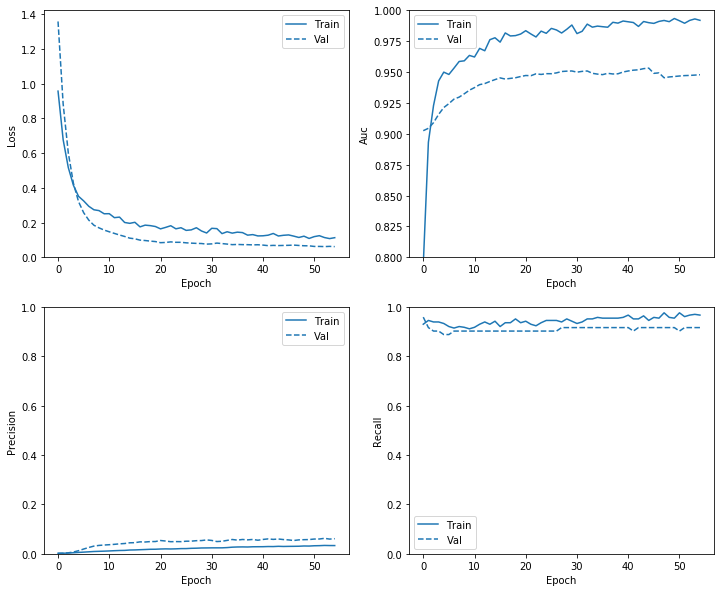

In [34]:
plot_metrics(weighted_history)

In [36]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07107227295637131
tp :  85.0
fp :  1384.0
tn :  55481.0
fn :  12.0
accuracy :  0.9754924178123474
precision :  0.05786249041557312
recall :  0.876288652420044
auc :  0.9744425415992737

合法的交易 (True Negatives):  55481
誤判的詐欺交易 (False Positives):  1384
遺漏的詐欺交易 (False Negatives):  12
檢測到詐欺交易 (True Positives):  85
總詐欺交易:  97


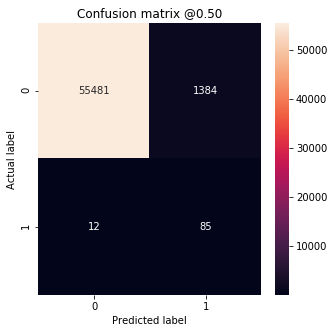

In [37]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

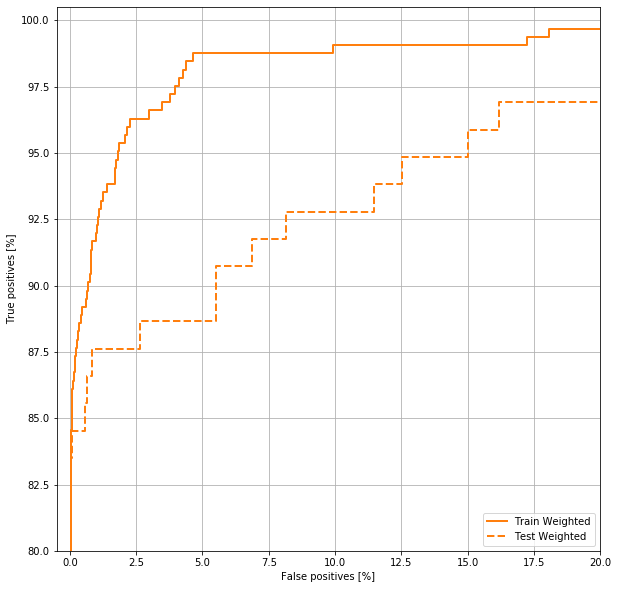

In [40]:
#ROC


plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')